In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import time
%matplotlib inline
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import pandas

Using TensorFlow backend.


In [2]:
import keras
import tensorflow

In [3]:
t=time.time()
train_data = np.array(list(np.loadtxt("train.csv", delimiter=","))).astype("float32")
train_labels = np.array(list(np.loadtxt("train_label.csv", delimiter=","))).astype("float32")
eval_data = np.array(list(np.loadtxt("eval.csv", delimiter=","))).astype("float32")
eval_labels = np.array(list(np.loadtxt("eval_label.csv", delimiter=","))).astype("float32")

#eval_data = pandas.read_csv("eval.csv", delimiter=",",header=None,dtype='float32')
#eval_labels = pandas.read_csv("eval_label.csv", delimiter=",",header=None,dtype='float32')
print(time.time()-t)

292.29607105255127


In [4]:
t=time.time()
test_data = np.array(list(np.loadtxt("H.csv", delimiter=","))).astype("float32")
test_labels = np.array(list(np.loadtxt("H_label.csv", delimiter=","))).astype("float32")
print(time.time()-t)

1.8290581703186035


In [5]:
x_train = train_data.reshape(-1, 24,24,3)
x_val = eval_data.reshape(-1, 24,24,3)
x_test = test_data.reshape(-1, 24,24,3)

y_train=np.abs(np.reshape(train_labels,(-1,4)))
y_val=np.abs(np.reshape(eval_labels,(-1,4)))
y_test=np.abs(np.reshape(test_labels,(-1,4)))

y_max=max(np.max(y_train[:,0]),np.max(y_val[:,0]))  #maximum observed chirality
y_train[:,0]=y_train[:,0]/y_max
y_val[:,0]=y_val[:,0]/y_max
y_test[:,0]=y_test[:,0]/y_max
print(y_max)
print(np.amax(y_train,axis=0),np.amax(y_val,axis=0))#,np.amax(y_test,axis=0))
print(np.shape(y_train),np.shape(x_train))

614.593
[1.        0.9875887 0.95      1.       ] [0.996756   0.98738945 0.95       1.        ]
(64000, 4) (64000, 24, 24, 3)


In [6]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (6, 6), activation='relu', input_shape = (24, 24, 3)))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
#model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(Dropout(0.5))

model.add(Dense(4, activation='sigmoid'))

In [7]:
model.compile(loss='mean_squared_error', optimizer = Adam(lr=1e-4))#, metrics=["accuracy"]) #binary_crossentropy

In [9]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [10]:
hist = model.fit(x=x_train, y=y_train, batch_size=512,
                           epochs=10, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val, y_val), #For speed
                           callbacks=[annealer])

Train on 64000 samples, validate on 16000 samples
Epoch 1/10
 - 114s - loss: 0.0179 - val_loss: 0.0070
Epoch 2/10
 - 4s - loss: 0.0044 - val_loss: 0.0045
Epoch 3/10
 - 4s - loss: 0.0037 - val_loss: 0.0030
Epoch 4/10
 - 4s - loss: 0.0033 - val_loss: 0.0025
Epoch 5/10
 - 4s - loss: 0.0031 - val_loss: 0.0022
Epoch 6/10
 - 4s - loss: 0.0029 - val_loss: 0.0029
Epoch 7/10
 - 4s - loss: 0.0028 - val_loss: 0.0019
Epoch 8/10
 - 3s - loss: 0.0027 - val_loss: 0.0022
Epoch 9/10
 - 3s - loss: 0.0026 - val_loss: 0.0021
Epoch 10/10
 - 3s - loss: 0.0025 - val_loss: 0.0022


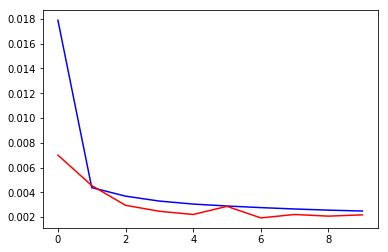

In [11]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()

In [ ]:
y_hat = model.predict(x_val)

In [ ]:
h_val=[]
h_hat=[]
for i in range(400):
    h_val.append(np.mean(y_val[i*40:(i+1)*40,0]))
    h_hat.append(np.mean(y_hat[i*40:(i+1)*40,0]))
plt.plot(h_val,'r')
plt.plot(h_hat,'b')
plt.show()
print(np.shape(y_hat))

In [ ]:
h_val=[]
h_hat=[]
for i in range(400):
    h_val.append(np.mean(y_val[i*40:(i+1)*40,1]))
    h_hat.append(np.mean(y_hat[i*40:(i+1)*40,1]))
plt.plot(h_val,'r')
plt.plot(h_hat,'b')
plt.show()
print(np.shape(y_hat))

In [ ]:
plt.plot(y_hat[:,2],'b')
plt.plot(y_val[:,2],'r')
plt.show()
print(np.shape(y_hat))

In [ ]:
plt.plot(y_hat[:,3],'b')
plt.plot(y_val[:,3],'r')
plt.show()
print(np.shape(y_hat))

In [ ]:
y_hat = model.predict(x_test)

In [ ]:
y_hat=np.array(list(np.loadtxt("y_hat.csv", delimiter=","))).astype("float32")
y_test=np.abs(np.reshape(test_labels,(-1,4)))

y_test=np.reshape(y_test,(20,20,100,4))
y_hat=np.reshape(y_hat,(20,20,100,4))

h_test=np.zeros((20,20,4))
h_hat=np.zeros((20,20,4))
for T in range(20):
    for B in range(20):
        for k in range(4):
            h_test[T,B,k]=np.mean(y_test[T,B,:,k])
            h_hat[T,B,k]=np.mean(y_hat[T,B,:,k])

plt.imshow(np.abs(h_test[:,:,0]-h_hat[:,:,0]))
plt.show()
plt.imshow(np.abs(h_test[:,:,1]-h_hat[:,:,1]))
plt.show()
plt.imshow(np.abs(h_test[:,:,2]-h_hat[:,:,2]))
plt.show()
plt.imshow(np.abs(h_test[:,:,3]-h_hat[:,:,3]))
plt.show()

np.savetxt('y_test0.5_0.5.csv',np.reshape(h_test,(400,4)),delimiter=',')
np.savetxt('y_hat0.5_0.5.csv',np.reshape(h_hat,(400,4)),delimiter=',')

h_test=np.reshape(h_test,(20,20,4))
h_hat=np.reshape(h_hat,(20,20,4))
for i in range(3):
    for j in range(4,20,5):
        plt.plot(h_test[:,j,i])
        plt.plot(h_hat[:,j,i])
        plt.show()
for j in range(4,20,5):
    plt.plot(h_test[j,:,3])
    plt.plot(h_hat[j,:,3])
    plt.show()     
h_test=np.reshape(h_test,(400,4))
h_hat=np.reshape(h_hat,(400,4))
print(np.mean(np.abs(h_test-h_hat),axis=0))
        

In [ ]:
y_hat = model.predict(x_test)

In [ ]:
y_test=np.abs(np.reshape(test_labels,(-1,4)))
y_test[:,0]=y_test[:,0]/(-np.max(y_test[:,0]))
y_test=np.reshape(test_labels,(20,20,100,4))
y_hat=np.reshape(y_hat,(20,20,100,4))

for T in range(0,20,5):
    h_test=[]
    h_hat=[]
    for B in range(20):
        h_test.append(T*0.1+np.mean(y_test[B,T,:,0]))
        h_hat.append(T*0.1+np.mean(y_hat[B,T,:,0]))
    plt.plot(h_test,'r')
    plt.plot(h_hat,'b')
plt.show()

for T in range(0,20,5):
    h_test=[]
    h_hat=[]
    for B in range(20):
        h_test.append(T*0.1+np.mean(y_test[B,T,:,1]))
        h_hat.append(T*0.1+np.mean(y_hat[B,T,:,1]))
    plt.plot(h_test,'r')
    plt.plot(h_hat,'b')
plt.show()

for T in range(0,20,5):
    h_test=[]
    h_hat=[]
    for B in range(20):
        h_test.append(T*0.1+np.mean(y_test[B,T,:,2]))
        h_hat.append(T*0.1+np.mean(y_hat[B,T,:,2]))
    plt.plot(h_test,'r')
    plt.plot(h_hat,'b')
plt.show()

for T in range(0,20,5):
    h_test=[]
    h_hat=[]
    for B in range(20):
        h_test.append(T*0.1+np.mean(y_test[B,T,:,3]))
        h_hat.append(T*0.1+np.mean(y_hat[B,T,:,3]))
    plt.plot(h_test,'r')
    plt.plot(h_hat,'b')
plt.show()

print(np.shape(y_hat))